In [1]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Data Collection
#### Dataset = https://www.kaggle.com/c/histopathologic-cancer-detection/data

In [2]:
original_dataset_path = '/datasets/histopathologic-cancer-detection/train'
csv_file_path = '/datasets/histopathologic-cancer-detection/train_labels.csv'

In [3]:
df = pd.read_csv(csv_file_path)
df = df.rename(columns={df.columns[0]: 'filename', df.columns[1]: 'label'})

# === CLASS MAPPING ===
label_map = {
    0: 'benign',
    1: 'malignant'
}
# ======================
df['label'] = df['label'].map(label_map)
df['filename'] = df['filename'].astype(str) + '.tif'

### EDA

In [4]:
print("Class distribution in original dataset:")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts.apply(lambda x: f"{x:.2%}").to_dict())

Class distribution in original dataset:
{'benign': '59.50%', 'malignant': '40.50%'}


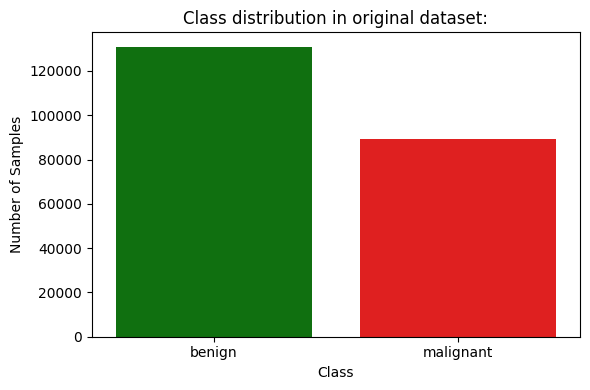

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', hue='label', palette=['green', 'red'], legend=False)
plt.title("Class distribution in original dataset:")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

### Sampling

In [6]:
# Define total number of samples
total_samples = 20000

# Compute number of samples per class based on ratio
samples_per_class = (class_counts * total_samples).round().astype(int)

# Sample from each class accordingly
sampled_dfs = []
for label, n_samples in samples_per_class.items():
    sampled_df = df[df['label'] == label].sample(n=n_samples, random_state=42)
    sampled_dfs.append(sampled_df)

# Concatenate and shuffle
new_df = pd.concat(sampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
print("Class distribution in new dataset:")
new_df_class_counts = new_df['label'].value_counts(normalize=True)
print(new_df_class_counts.apply(lambda x: f"{x:.2%}").to_dict())

Class distribution in new dataset:
{'benign': '59.49%', 'malignant': '40.51%'}


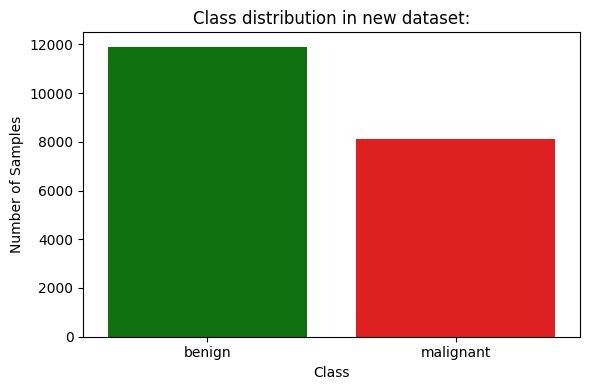

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data=new_df, x='label', hue='label', palette=['green', 'red'], legend=False)
plt.title("Class distribution in new dataset:")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

### Data Spliting

In [9]:
# === SPLIT RATIOS ===
split_ratios = {
    'train': 0.7,
    'val': 0.15,
    'test': 0.15
}

train_df, temp_df = train_test_split(new_df, test_size=1 - split_ratios['train'], stratify=new_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=split_ratios['test'] / (split_ratios['val'] + split_ratios['test']),
                                   stratify=temp_df['label'], random_state=42)

splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

In [10]:

project_folder = './'
original_dataset_dir = os.path.join(project_folder, '..', original_dataset_path)
new_dataset_dir = os.path.join(project_folder, 'dataset')

# === CREATE NEW DIRECTORY STRUCTURE ===
for split_name in splits:
    for class_name in label_map.values():
        os.makedirs(os.path.join(new_dataset_dir, split_name, class_name), exist_ok=True)

# === COPY FILES ===
def copy_split_files(split_name, split_df):
    for _, row in split_df.iterrows():
        src_path = os.path.join(original_dataset_dir, row['filename'])
        dst_path = os.path.join(new_dataset_dir, split_name, row['label'], row['filename'])
        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
        else:
            print(f"[WARNING] File not found: {src_path}")

for split_name, split_df in splits.items():
    print(f"Copying {split_name} files...")
    copy_split_files(split_name, split_df)

print("All files copied and dataset split with original class balance.")


Copying train files...
Copying val files...
Copying test files...
All files copied and dataset split with original class balance.


## Data Preprocessing

### Data Transformation

In [11]:
# Batch size
batch_size = 32

# Image size
img_size = 96

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


### Data Loading

In [12]:
# Paths
data_dir = './dataset'
train_dir = os.path.join(data_dir, 'train')
val_dir   = os.path.join(data_dir, 'val')
test_dir  = os.path.join(data_dir, 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=4)

print(train_dataset.class_to_idx)  # {'benign': 0, 'malignant': 1}

{'benign': 0, 'malignant': 1}


## Model Training

In [13]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


In [14]:
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-B0
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2).to(device)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.405, 0.595]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50

In [16]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * images.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

Epoch 1/50 - Train Loss: 1.6377 Acc: 0.7481 | Val Loss: 1.0713 Acc: 0.8010
Epoch 2/50 - Train Loss: 0.9904 Acc: 0.8153 | Val Loss: 0.8727 Acc: 0.8360
Epoch 3/50 - Train Loss: 0.6599 Acc: 0.8398 | Val Loss: 0.6919 Acc: 0.8550
Epoch 4/50 - Train Loss: 0.4781 Acc: 0.8536 | Val Loss: 0.3512 Acc: 0.8853
Epoch 5/50 - Train Loss: 0.3899 Acc: 0.8668 | Val Loss: 0.3213 Acc: 0.8797
Epoch 6/50 - Train Loss: 0.3249 Acc: 0.8830 | Val Loss: 0.2834 Acc: 0.8993
Epoch 7/50 - Train Loss: 0.2829 Acc: 0.8920 | Val Loss: 0.2578 Acc: 0.9027
Epoch 8/50 - Train Loss: 0.2639 Acc: 0.8986 | Val Loss: 0.2293 Acc: 0.9107
Epoch 9/50 - Train Loss: 0.2515 Acc: 0.9039 | Val Loss: 0.2377 Acc: 0.9063
Epoch 10/50 - Train Loss: 0.2417 Acc: 0.9080 | Val Loss: 0.2181 Acc: 0.9213
Epoch 11/50 - Train Loss: 0.2208 Acc: 0.9184 | Val Loss: 0.2038 Acc: 0.9263
Epoch 12/50 - Train Loss: 0.2207 Acc: 0.9140 | Val Loss: 0.2228 Acc: 0.9203
Epoch 13/50 - Train Loss: 0.2098 Acc: 0.9216 | Val Loss: 0.2049 Acc: 0.9247
Epoch 14/50 - Train L

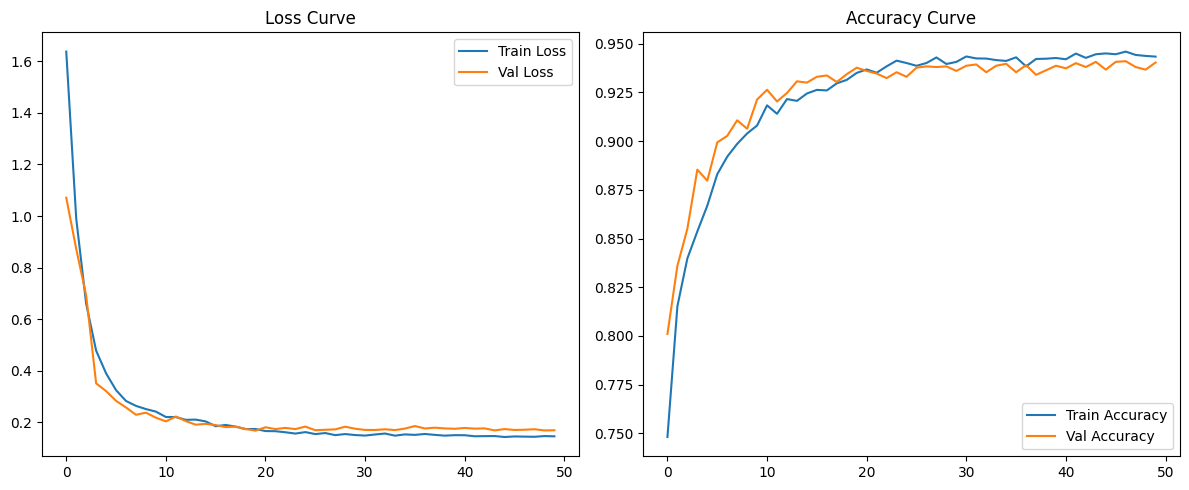

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()

In [18]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9347
